In [1]:
import emip_toolkit as emtk
import filter_fixation as ff
import numpy as np
import pandas as pd
import json
import time
import copy

%matplotlib tk      
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext autoreload
%autoreload 2

In [7]:
list(centers.values())[0][0]

968.8649567130592

In [2]:
def draw(centers):
    fixs = []
    for data in centers.values():
        if data[0] == -1 and data[1] == -1: continue
        elif data[0] == -2 and data[1] == -2: continue
        else:
            x, y, duration = data
            fixs.append([x, y])
    fixs = np.array(fixs)
    
    l = plt.plot(fixs[:, 0], fixs[:, 1], alpha=0.4, c='orange')
    line = l.pop(0)
    
    scatter_color = ['yellow'] * len(fixs)
    if list(centers.values())[0][0] != -2: scatter_color[0] = 'red'
    scatter = plt.scatter(fixs[:, 0], fixs[:, 1], alpha=0.5, s=100, c=scatter_color)
    return line, scatter

def is_fixation(x, y, centers):
    if find_index(centers):
        # Empty space exists, new fixation needs to be drawn
        return None
    for index, (c_x, c_y, duration) in centers.items():
        # If click is on one fixation -> Hide it
        if c_x-12 < x < c_x+12 and c_y-12 < y < c_y+12:
            return index
    return None

def find_index(centers):
    for index, data in centers.items():
        if data[0] == -1 and data[1] == -1:
            return index
    return None

def changed_fix(participant_id):
    count = 0
    original = f'originals/R8S1_{participant_id}_ORIGINAL.json'
    with open(original, 'r') as file:
        original = json.loads(file.read())
        
    corrected = f'corrections/R8S1_{participant_id}_CORRECTED.json'
    with open(corrected, 'r') as file:
        corrected = json.loads(file.read())
    for key in original:
        if original[key] != corrected[key]:
            count += 1
    return count, len(original)

In [13]:
start = time.time()
fig = plt.figure(figsize=(12,8))

path = 'datasets/GazeBase_TEX/Data/S_8331_S1_TEX.csv'

pixel_data = ff.process_GazeBase(path)
fixations, saccades = ff.filter_fixations(pixel_data)

path = path.split('/')[-1]
trial_id = int(path[8])
round_id = path[2]
participant_id = path[3:6]
imagepath = f"datasets/GazeBase_TEX/StimuliExamples/TEXScreenshots/TEX_R{round_id}S{trial_id}_bg.png"

img = mpimg.imread(imagepath)

# Initialize fixation centers
centers = {}
for index, fixation in fixations.items():
    fixation = fixation.get_fixation()
    duration = fixation[3]
    if duration < 100:
        continue
    x = fixation[4]
    y = fixation[5]
    centers[index] = [x, y, duration]

line, scatter = draw(centers)
history = []

def onclick(event):
    global line, scatter, centers, clicked, history

    if event.button == 1:
        x, y = event.xdata, event.ydata
        index = is_fixation(x, y, centers)

        if index:
            # If click is on one fixation -> Hide it
            history.append(copy.deepcopy(centers))
            centers[index][0] = -1
            centers[index][1] = -1
        else:
            # If click is on empty spot -> Find empty spot and fill with current position
            index = find_index(centers)
            if index:
                centers[index][0] = x
                centers[index][1] = y

        line.remove()
        scatter.remove()

        line, scatter = draw(centers)
        fig.canvas.draw()

        with open(f'corrections/R{round_id}S{trial_id}_{participant_id}_CORRECTED.json', 'w') as file:
            file.write(json.dumps(centers))
    elif event.button == 3:
        x, y = event.xdata, event.ydata
        index = is_fixation(x, y, centers)
        
        if index:
            history.append(copy.deepcopy(centers))
            centers[index][0] = -2
            centers[index][1] = -2
            
        line.remove()
        scatter.remove()

        line, scatter = draw(centers)
        fig.canvas.draw()

        with open(f'corrections/R{round_id}S{trial_id}_{participant_id}_CORRECTED.json', 'w') as file:
            file.write(json.dumps(centers))

    
def onpress(event):
    global history, line, scatter, centers

    if event.key == 'z':
        if len(history) > 0:
            centers = history.pop()

            line.remove()
            scatter.remove()

            line, scatter = draw(centers)
            fig.canvas.draw()

            with open(f'corrections/R{round_id}S{trial_id}_{participant_id}_CORRECTED.json', 'w') as file:
                file.write(json.dumps(centers))

def onclose(event):
    global participant_id
    end = time.time()
    total_time = round(end-start, 2)
    
    changed_fixations, total_fixations = changed_fix(participant_id)
    
    with open(f'corrections/R{round_id}S{trial_id}_{participant_id}_CORRECTED.json', 'r') as file:
        fixations_data = json.loads(file.read())
    
    output = {}
    output['total_time'] = total_time
    output['changed_fixations'] = changed_fixations
    output['total_fixations'] = total_fixations
    output['fixations_data'] = fixations_data
    
    with open(f'corrections/R{round_id}S{trial_id}_{participant_id}_CORRECTED.json', 'w') as file:
        file.write(json.dumps(output))

cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid2 = fig.canvas.mpl_connect('close_event', onclose)
cid3 = fig.canvas.mpl_connect('key_press_event', onpress)
imgplot = plt.imshow(img)
plt.show()

1. First fixation in entire trial red
2. Undo button
3. Many undo

In [36]:
filenames = ['R8S1_215_CORRECTED.json', 'R8S1_271_CORRECTED.json', 'R8S1_120_CORRECTED.json', 'R8S1_207_CORRECTED.json', 'R8S1_128_CORRECTED.json', 'R8S1_288_CORRECTED.json', 'R8S1_216_CORRECTED.json', 'R8S1_285_CORRECTED.json', 'R8S1_043_CORRECTED.json', 'R8S1_152_CORRECTED.json', 'R8S1_136_CORRECTED.json', 'R8S1_137_CORRECTED.json', 'R8S1_154_CORRECTED.json', 'R8S1_314_CORRECTED.json', 'R8S1_217_CORRECTED.json', 'R8S1_063_CORRECTED.json', 'R8S1_007_CORRECTED.json', 'R8S1_064_CORRECTED.json', 'R8S1_249_CORRECTED.json', 'R8S1_001_CORRECTED.json', 'R8S1_196_CORRECTED.json', 'R8S1_244_CORRECTED.json', 'R8S1_107_CORRECTED.json', 'R8S1_259_CORRECTED.json', 'R8S1_331_CORRECTED.json', 'R8S1_179_CORRECTED.json', 'R8S1_016_CORRECTED.json', 'R8S1_192_CORRECTED.json', 'R8S1_180_CORRECTED.json']

In [37]:
for file in filenames:
    print(file)
    participant = file.split('.')[0][5:8]
    path = 'datasets/GazeBase_TEX/Data/S_8' + participant + '_S1_TEX.csv'

    pixel_data = ff.process_GazeBase(path)
    fixations, saccades = ff.filter_fixations(pixel_data)

    path = path.split('/')[-1]
    trial_id = int(path[8])
    round_id = path[2]
    participant_id = path[3:6]
    imagepath = f"datasets/GazeBase_TEX/StimuliExamples/TEXScreenshots/TEX_R{round_id}S{trial_id}_bg.png"


# Initialize fixation centers
    centers = {}
    for index, fixation in fixations.items():
        fixation = fixation.get_fixation()
        duration = fixation[3]
        if duration < 100:
            continue
        x = fixation[4]
        y = fixation[5]
        centers[index] = [x, y, duration]
    
    with open('originals/R8S1_' + participant + '_ORIGINAL.json', 'w') as output:
        output.write(json.dumps(centers))

R8S1_215_CORRECTED.json
R8S1_271_CORRECTED.json
R8S1_120_CORRECTED.json
R8S1_207_CORRECTED.json
R8S1_128_CORRECTED.json
R8S1_288_CORRECTED.json
R8S1_216_CORRECTED.json
R8S1_285_CORRECTED.json
R8S1_043_CORRECTED.json
R8S1_152_CORRECTED.json
R8S1_136_CORRECTED.json
R8S1_137_CORRECTED.json
R8S1_154_CORRECTED.json
R8S1_314_CORRECTED.json
R8S1_217_CORRECTED.json
R8S1_063_CORRECTED.json
R8S1_007_CORRECTED.json
R8S1_064_CORRECTED.json
R8S1_249_CORRECTED.json
R8S1_001_CORRECTED.json
R8S1_196_CORRECTED.json
R8S1_244_CORRECTED.json
R8S1_107_CORRECTED.json
R8S1_259_CORRECTED.json
R8S1_331_CORRECTED.json
R8S1_179_CORRECTED.json
R8S1_016_CORRECTED.json
R8S1_192_CORRECTED.json
R8S1_180_CORRECTED.json


In [37]:
for file in filenames:
    with open('corrections/' + file) as correction:
        cor = json.loads(correction.read())
    participant_id = file.split('.')[0]
    with open('ori/' + participant_id + '_ORIGINAL.json') as original:
        ori = json.loads(original.read())
        
        print(file, len(cor) == len(ori))

R8S1_192.txt True
R8S1_179.txt True
R8S1_152.txt True
R8S1_180.txt True
R8S1_154.txt True
R8S1_196.txt True
R8S1_244.txt True
R8S1_331.txt True
R8S1_285.txt True
R8S1_120.txt True
R8S1_043.txt False
R8S1_137.txt True
R8S1_136.txt True
R8S1_259.txt True
R8S1_271.txt True
R8S1_107.txt True
R8S1_064.txt True
R8S1_288.txt True
R8S1_128.txt True
R8S1_314.txt True
R8S1_249.txt True
R8S1_063.txt True
R8S1_207.txt True
R8S1_007.txt False
R8S1_016.txt False
R8S1_215.txt True
R8S1_001.txt False
R8S1_217.txt True
R8S1_216.txt True


In [48]:
for file in filenames:
    new_output = {}
    with open('corrections/' + file) as correction:
        cor = json.loads(correction.read())
    for key in cor:
        if cor[key][2] >= 90:
            new_output[key] = cor[key]
    with open('ori/' + file.replace('.txt', '') + '_CORRECTED.json', 'w') as output:
        output.write(json.dumps(new_output))

In [50]:
for file in filenames:
    with open('ori/' + file.replace('.txt', '_CORRECTED.json')) as correction:
        cor = json.loads(correction.read())
    participant_id = file.split('.')[0]
    with open('originals/' + participant_id + '_ORIGINAL.json') as original:
        ori = json.loads(original.read())
        
        print(file, len(cor), len(ori))

R8S1_192.txt 264 264
R8S1_179.txt 246 246
R8S1_152.txt 233 233
R8S1_180.txt 271 271
R8S1_154.txt 211 211
R8S1_196.txt 199 199
R8S1_244.txt 245 245
R8S1_331.txt 215 215
R8S1_285.txt 250 250
R8S1_120.txt 217 217
R8S1_043.txt 219 219
R8S1_137.txt 118 118
R8S1_136.txt 139 139
R8S1_259.txt 224 224
R8S1_271.txt 189 189
R8S1_107.txt 214 214
R8S1_064.txt 189 189
R8S1_288.txt 257 257
R8S1_128.txt 217 217
R8S1_314.txt 255 255
R8S1_249.txt 232 232
R8S1_063.txt 218 218
R8S1_207.txt 224 224
R8S1_007.txt 229 229
R8S1_016.txt 186 186
R8S1_215.txt 229 229
R8S1_001.txt 256 256
R8S1_217.txt 229 229
R8S1_216.txt 142 142


In [34]:
len(ori)

219

In [14]:
%matplotlib inline

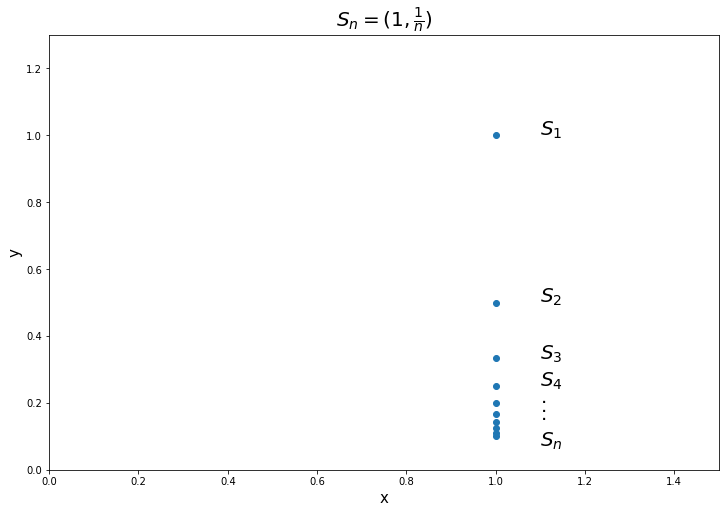

In [76]:
plt.figure(figsize=(12,8))
plt.scatter([1]*10, np.array([1]*10)/range(1, 11))
plt.xlim(0,1.5)
plt.ylim(0,1.3)
plt.annotate(xy=(1.1,1.0), text='$S_1$', size=20)
plt.annotate(xy=(1.1,0.5), text='$S_2$', size=20)
plt.annotate(xy=(1.1,0.33), text='$S_3$', size=20)
plt.annotate(xy=(1.1,0.25), text='$S_4$', size=20)
plt.annotate(xy=(1.1,0.20), text='$.$', size=20)
plt.annotate(xy=(1.1,0.175), text='$.$', size=20)
plt.annotate(xy=(1.1,0.15), text='$.$', size=20)
plt.annotate(xy=(1.1,0.07), text='$S_n$', size=20)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
plt.title('$S_n = (1, \\frac{1}{n})$', size=20)
plt.savefig('Graph1.png')

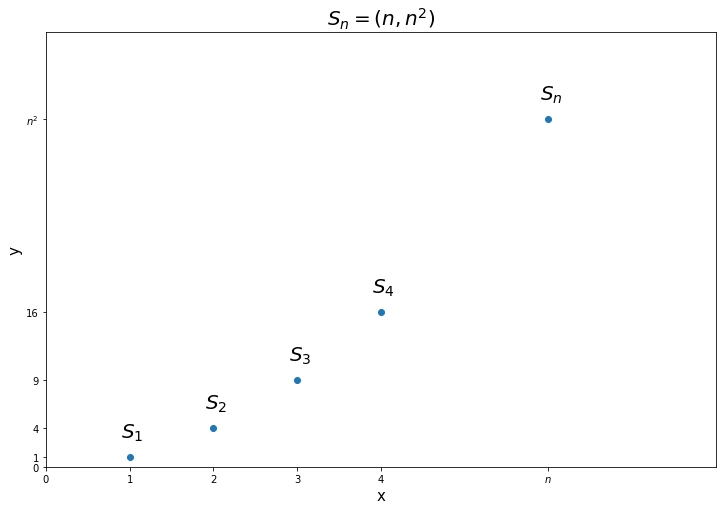

In [75]:
plt.figure(figsize=(12,8))
plt.scatter([1,2,3,4, 6, 10], np.array([1,2,3,4,6, 10]) ** 2)
plt.xlim(0,8)
plt.ylim(0,45)
plt.annotate(xy=(0.9,3), text='$S_1$', size=20)
plt.annotate(xy=(1.9,6), text='$S_2$', size=20)
plt.annotate(xy=(2.9,11), text='$S_3$', size=20)
plt.annotate(xy=(3.9,18), text='$S_4$', size=20)
plt.annotate(xy=(5.9,38), text='$S_n$', size=20)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
plt.xticks([0,1,2,3,4,6])
plt.gca().set_xticklabels([0,1,2,3,4,'$n$'], size=10)
plt.yticks([0,1,4,9,16,36])
plt.gca().set_yticklabels([0,1,4,9,16,'$n^2$'], size=10)
plt.title('$S_n = (n, n^2)$', size=20)
plt.savefig('Graph2.png')